# CIFAR‑10 with a Simple MLP (Super‑Basic Tutorial)

This notebook mirrors your PyTorch pipeline and keeps the essentials:
**load → build → train → evaluate → visualize**.

You’ll get:
- Reproducible setup and automatic CUDA selection
- Normalized CIFAR‑10 loaders with a validation split
- Your exact MLP: `Flatten → Linear(3072→64) → ReLU → Linear(64→32) → ReLU → Linear(32→10)`
- Simple training loop + loss/accuracy plots
- Test metrics, confusion matrix, and a grid of misclassified images


# 1 — Setup, seed, device, transforms (with normalization)

In [3]:
import os, random, numpy as np, torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
from torchvision import transforms
import matplotlib.pyplot as plt

# 1) Reproducibility + device
def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# 2) CIFAR‑10 transforms (normalize) + tiny visualization helper
mean = [0.4914, 0.4822, 0.4465]
std  = [0.2470, 0.2435, 0.2616]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

inv_norm = transforms.Normalize(
    mean=[-m/s for m,s in zip(mean, std)],
    std=[1/s for s in std]
)

classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

def show_batch(images, labels, n=16, title=None):
    # images: (B,3,32,32) normalized; inverse norm for display
    imgs = [inv_norm(images[i]).permute(1,2,0).clamp(0,1).cpu().numpy() for i in range(min(n, images.size(0)))]
    cols = 8; rows = (len(imgs)+cols-1)//cols
    fig, axs = plt.subplots(rows, cols, figsize=(cols*1.6, rows*1.6))
    axs = axs.ravel() if rows*cols>1 else [axs]
    for i, img in enumerate(imgs):
        axs[i].imshow(img); axs[i].set_title(classes[labels[i].item()], fontsize=9)
        axs[i].axis('off')
    for j in range(i+1, rows*cols): axs[j].axis('off')
    if title: fig.suptitle(title)
    plt.tight_layout(); plt.show()


Device: cpu


# 2 — Data (train/val/test) and a quick look

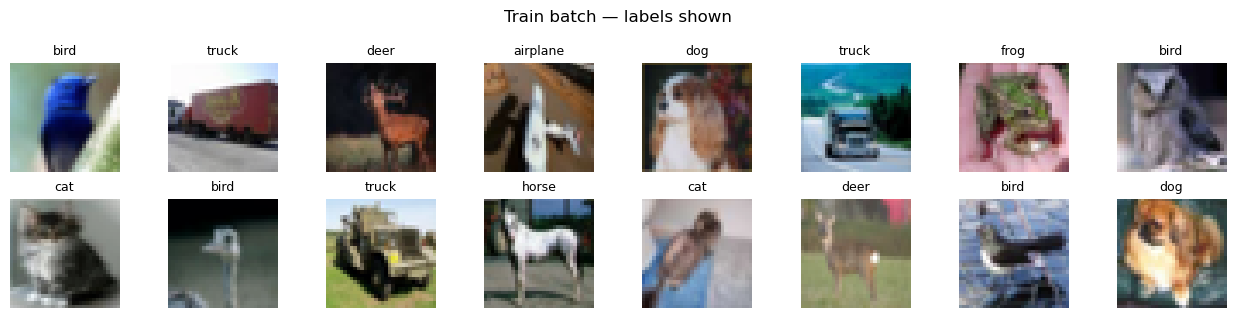

In [8]:
# Load + split
trainval = CIFAR10(os.getcwd(), train=True,  download=True, transform=transform)
N = len(trainval); n_val = 5000
train_set, val_set = random_split(trainval, [N-n_val, n_val], generator=torch.Generator().manual_seed(42))
test_set  = CIFAR10(os.getcwd(), train=False, download=True, transform=transform)

trainloader = DataLoader(train_set, batch_size=64, shuffle=True,  num_workers=4) #pin_memory=True
valloader   = DataLoader(val_set,   batch_size=128, shuffle=False, num_workers=4) # pin_memory=True
testloader  = DataLoader(test_set,  batch_size=128, shuffle=False, num_workers=4) # pin_memory=True

# Visual sanity check: one batch
images, labels = next(iter(trainloader))
show_batch(images, labels, n=16, title='Train batch — labels shown')


# 3 — Your exact MLP (Flatten→64→32→10) and compile bits

In [11]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32*3, 64), nn.ReLU(),
            nn.Linear(64, 32),      nn.ReLU(),
            nn.Linear(32, 10)
        )
    def forward(self, x):
        return self.layers(x)

model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


# 4 — Simple training loop (≤ 15 epochs) + live curves

Epoch 01 | train 1.8667 | val 1.7155 | val_acc 0.3910
Epoch 02 | train 1.6477 | val 1.6235 | val_acc 0.4288
Epoch 03 | train 1.5637 | val 1.5726 | val_acc 0.4488
Epoch 04 | train 1.5083 | val 1.5319 | val_acc 0.4660
Epoch 05 | train 1.4675 | val 1.5093 | val_acc 0.4676
Epoch 06 | train 1.4335 | val 1.4993 | val_acc 0.4728
Epoch 07 | train 1.4052 | val 1.4715 | val_acc 0.4834
Epoch 08 | train 1.3809 | val 1.4633 | val_acc 0.4844
Epoch 09 | train 1.3585 | val 1.4547 | val_acc 0.4846
Epoch 10 | train 1.3386 | val 1.4496 | val_acc 0.4870
Epoch 11 | train 1.3193 | val 1.4456 | val_acc 0.4882
Epoch 12 | train 1.3030 | val 1.4464 | val_acc 0.4900
Epoch 13 | train 1.2855 | val 1.4372 | val_acc 0.4874
Epoch 14 | train 1.2708 | val 1.4274 | val_acc 0.4952
Epoch 15 | train 1.2560 | val 1.4244 | val_acc 0.4996


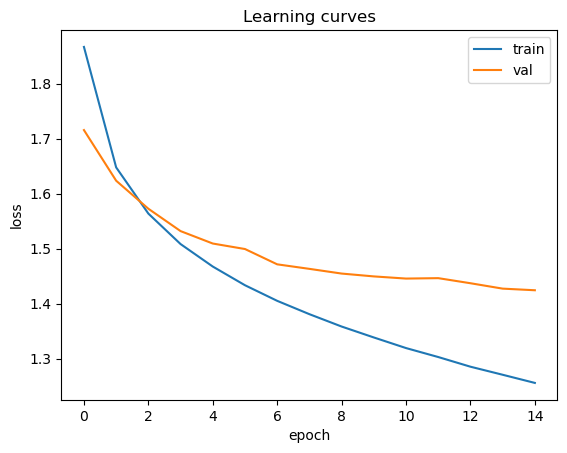

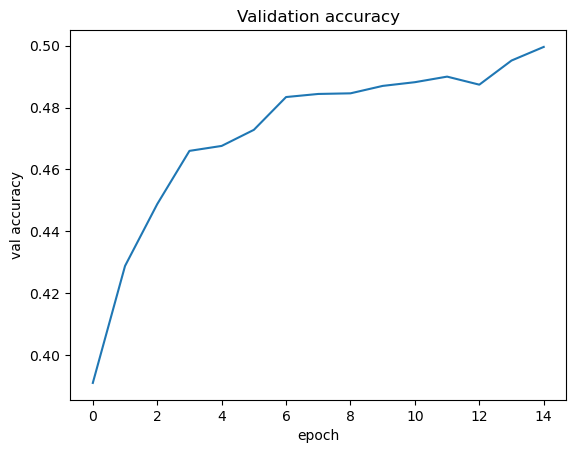

In [14]:
train_loss_hist, val_loss_hist, val_acc_hist = [], [], []

for epoch in range(15):
    # train
    model.train(); running = 0.0
    for x,y in trainloader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward(); optimizer.step()
        running += loss.item()*x.size(0)
    train_loss = running/len(trainloader.dataset)

    # validate
    model.eval(); vloss=0.0; correct=0
    with torch.no_grad():
        for x,y in valloader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            vloss += criterion(out,y).item()*x.size(0)
            pred = out.argmax(1)
            correct += (pred==y).sum().item()
    val_loss = vloss/len(valloader.dataset)
    val_acc = correct/len(valloader.dataset)

    train_loss_hist.append(train_loss); val_loss_hist.append(val_loss); val_acc_hist.append(val_acc)
    print(f"Epoch {epoch+1:02d} | train {train_loss:.4f} | val {val_loss:.4f} | val_acc {val_acc:.4f}")

# Plot learning curves
plt.figure(); plt.plot(train_loss_hist, label='train'); plt.plot(val_loss_hist, label='val'); plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(); plt.title('Learning curves'); plt.show()
plt.figure(); plt.plot(val_acc_hist); plt.xlabel('epoch'); plt.ylabel('val accuracy'); plt.title('Validation accuracy'); plt.show()


# 5 — Test metrics, confusion matrix, and misclassified samples

Test accuracy: 0.5026


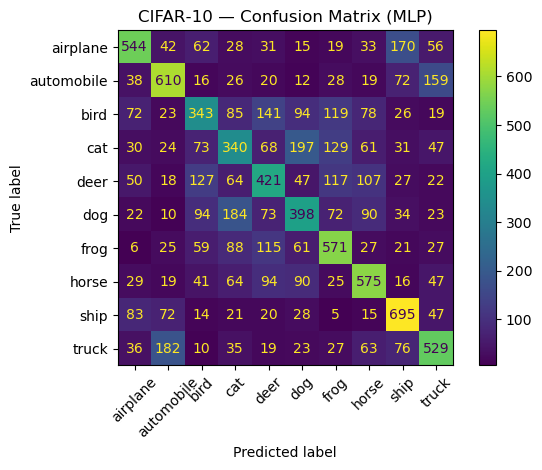

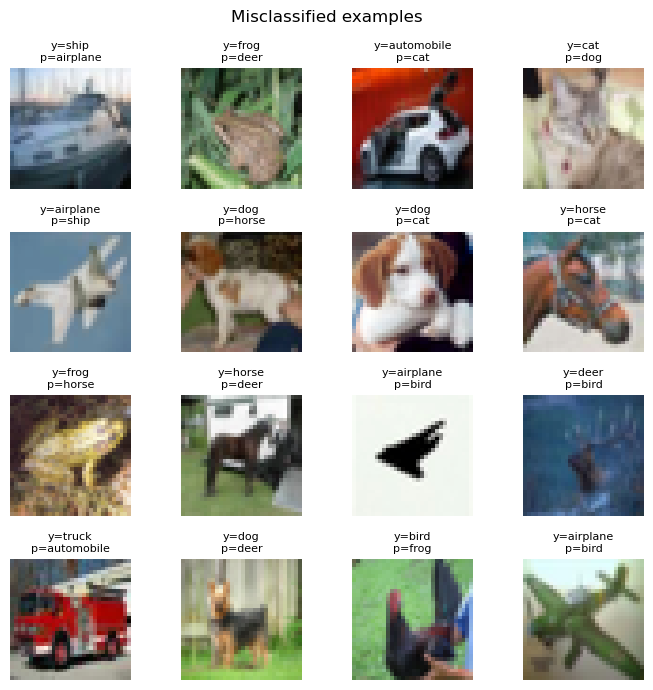

              precision    recall  f1-score   support

    airplane     0.5978    0.5440    0.5696      1000
  automobile     0.5951    0.6100    0.6025      1000
        bird     0.4088    0.3430    0.3730      1000
         cat     0.3636    0.3400    0.3514      1000
        deer     0.4202    0.4210    0.4206      1000
         dog     0.4124    0.3980    0.4051      1000
        frog     0.5135    0.5710    0.5407      1000
       horse     0.5384    0.5750    0.5561      1000
        ship     0.5950    0.6950    0.6411      1000
       truck     0.5420    0.5290    0.5354      1000

    accuracy                         0.5026     10000
   macro avg     0.4987    0.5026    0.4996     10000
weighted avg     0.4987    0.5026    0.4996     10000



In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np

# Test pass
model.eval(); correct=0; total=0; all_p=[]; all_y=[]; all_x=[]
with torch.no_grad():
    for x,y in testloader:
        x = x.to(device)
        logits = model(x)
        p = logits.argmax(1).cpu().numpy()
        all_p.append(p); all_y.append(y.numpy()); all_x.append(x.cpu())
        correct += (p == y.numpy()).sum(); total += y.size(0)

test_acc = correct/total
print(f"Test accuracy: {test_acc:.4f}")

all_p = np.concatenate(all_p); all_y = np.concatenate(all_y)
cm = confusion_matrix(all_y, all_p)
ConfusionMatrixDisplay(cm, display_labels=classes).plot(xticks_rotation=45)
plt.title('CIFAR‑10 — Confusion Matrix (MLP)'); plt.tight_layout(); plt.show()

# Show 16 misclassified
mis = np.where(all_p!=all_y)[0][:16]
if len(mis)>0:
    xs = torch.cat(all_x)  # (N,3,32,32)
    fig, axs = plt.subplots(4,4, figsize=(7,7))
    axs = axs.ravel()
    for i,k in enumerate(mis):
        img = inv_norm(xs[k]).permute(1,2,0).clamp(0,1)
        axs[i].imshow(img)
        axs[i].set_title(f"y={classes[all_y[k]]}\np={classes[all_p[k]]}", fontsize=8)
        axs[i].axis('off')
    plt.suptitle('Misclassified examples'); plt.tight_layout(); plt.show()

print(classification_report(all_y, all_p, target_names=classes, digits=4))


# 6 — Try a Tiny CNN to compare with the MLP

This cell is optional and demonstrates why convolutional inductive bias helps on images. It trains quickly for a few epochs to show a **baseline gap** vs. MLP.

In [20]:
class TinyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # 16x16x16
            nn.Conv2d(16,32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # 32x8x8
            nn.Flatten(),
            nn.Linear(32*8*8, 64), nn.ReLU(),
            nn.Linear(64, 10)
        )
    def forward(self, x): return self.net(x)

cnn = TinyCNN().to(device)
opt = torch.optim.Adam(cnn.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()

for epoch in range(5):
    cnn.train(); run=0
    for x,y in trainloader:
        x,y = x.to(device), y.to(device)
        opt.zero_grad(); out = cnn(x); loss = crit(out,y)
        loss.backward(); opt.step(); run += loss.item()*x.size(0)
    vloss, vacc = 0.0, 0
    cnn.eval();
    with torch.no_grad():
        for x,y in valloader:
            x,y = x.to(device), y.to(device)
            o = cnn(x); vloss += crit(o,y).item()*x.size(0)
            vacc += (o.argmax(1)==y).sum().item()
    print(f"[TinyCNN] Epoch {epoch+1} | val_loss={(vloss/len(valloader.dataset)):.4f} | val_acc={(vacc/len(valloader.dataset)):.4f}")

# quick test
cnn.eval(); corr=0; tot=0
with torch.no_grad():
    for x,y in testloader:
        x = x.to(device)
        p = cnn(x).argmax(1).cpu().numpy()
        corr += (p == y.numpy()).sum(); tot += y.size(0)
print(f"[TinyCNN] Test accuracy: {corr/tot:.4f}")


[TinyCNN] Epoch 1 | val_loss=1.2990 | val_acc=0.5278
[TinyCNN] Epoch 2 | val_loss=1.0771 | val_acc=0.6260
[TinyCNN] Epoch 3 | val_loss=1.0133 | val_acc=0.6348
[TinyCNN] Epoch 4 | val_loss=0.9559 | val_acc=0.6692
[TinyCNN] Epoch 5 | val_loss=0.9515 | val_acc=0.6752
[TinyCNN] Test accuracy: 0.6701
